<a href="https://colab.research.google.com/github/Jimin980921/Gan/blob/master/Gan_0129.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Wed Jan 29 09:05:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    13W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!git clone https://github.com/Jimin980921/Gan.git

Cloning into 'Gan'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [0]:
ls -ltr

total 8
drwxr-xr-x 1 root root 4096 Jan 13 16:38 sample_data/
drwxr-xr-x 3 root root 4096 Jan 29 09:09 Gan/


## 모듈 정의

In [1]:
import argparse

import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, Sequential  #keras는 파이썬으로 작성된 오픈 소스 신경망 라이브러리이다.
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K


K.set_image_data_format('channels_first')

Using TensorFlow backend.


## **데이터셋** **정의**

D의 목표는 FAKE, REAL를 제대로 분류하는 것

G의 목표는 완벽하게 D가 틀리도록 하는 것

In [0]:
class Data:
    """
    Define dataset for training GAN
    """
    def __init__(self, batch_size, z_input_dim):
        # load mnist dataset
        # 이미지는 보통 -1~1 사이의 값으로 normalization : generator의 outputlayer를 tanh로
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        self.x_data = ((X_train.astype(np.float32) - 127.5) / 127.5)  #normalization
        self.x_data = self.x_data.reshape((self.x_data.shape[0], 1) + self.x_data.shape[1:])  #?
        self.batch_size = batch_size
        self.z_input_dim = z_input_dim   


    def get_real_sample(self):    #난수생성=x_data의 하나의 사진을 가져옴.
        """
        get real sample mnist images

        :return: batch_size number of mnist image data
        """
        return self.x_data[np.random.randint(0, self.x_data.shape[0], size=self.batch_size)]   
        #randint=첫번째파라미터~두번째파라미터-1 사이의 숫자중에 size만큼의 난수를 생성

    def get_z_sample(self, sample_size):   #사진의 픽셀을 바꾸는것.
        """
        get z sample data

        :return: random z data (batch_size, z_input_dim) size
        """
        return np.random.uniform(-1.0, 1.0, (sample_size, self.z_input_dim))
        #-1과 1사이에서 균등분포로부터 난수 생성 (sample_size, z_input_dim)모양으로

In [0]:
data = Data(batch_size=2, z_input_dim=10)
print(data.get_real_sample())

[[[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]


 [[[-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   ...
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]
   [-1. -1. -1. ... -1. -1. -1.]]]]


In [0]:
print(data.get_z_sample(2))
#2는 sample size, z_input_dim=10  2행 10열

[[ 0.54167005 -0.53803209 -0.87002523 -0.58936875 -0.02214873 -0.86341462
  -0.20626911 -0.77569973 -0.92787439  0.5276947 ]
 [ 0.62708418  0.03746251  0.54379347 -0.56391017  0.14587568 -0.88111752
   0.6342111   0.87135084 -0.15363093 -0.6315288 ]]


# **GAN의 모델 정의**

discriminator: 이미지 판별

generator: input z(noise)를 확정한 뒤 CNN생성기로 모델링

In [0]:
class GAN:
    def __init__(self, learning_rate, z_input_dim):
        """
        init params

        :param learning_rate: learning rate of optimizer
        :param z_input_dim: input dim of z
        """
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.D = self.discriminator()
        self.G = self.generator()
        self.GD = self.combined()

    def discriminator(self):   #판별자
        """
        define discriminator
        """
        D = Sequential()
        D.add(Conv2D(256, (5, 5),
                     padding='same',
                     input_shape=(1,28,28),   #위에 선언을 channels_first라고 함.
                     kernel_initializer=initializers.RandomNormal(stddev=0.02)))
        #컨볼루션 레이어 정의
        #첫번째 인자: convolution 필터 수  5*5가 256개있음.
        #두번째 인자: convolution 커널의 (행,열)
        #padding은 same은 출력 이미지 사이즈와 입력 이미지 사이즈와 동일
        #input_shape는 모델에서 첫 레이어일때만 정의 (행,열,채널 수)


        D.add(LeakyReLU(0.2))
        #활성화
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        #pool_size : 수직, 수평 축소 비율을 지정합니다. (2, 2)이면 출력 영상 크기는 입력 영상 크기의 반으로 줄어듬.
        D.add(Dropout(0.3))
        #0.3비율로
        D.add(Conv2D(512, (5, 5), padding='same'))
        D.add(LeakyReLU(0.2))
        D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
        D.add(Dropout(0.3))
        D.add(Flatten())
        #전결합층에 전달하기 위해서 1차원으로 바꿔줌.

        D.add(Dense(256))
        #Dense는 입력과 출력을 모두 연결해줌.
        D.add(LeakyReLU(0.2))
        D.add(Dropout(0.3))
        D.add(Dense(1, activation='sigmoid'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        #적절한 가중치,편향 찾음.
        D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return D

    def generator(self):   #생성자
        """
        define generator
        """
        G = Sequential()
        G.add(Dense(512, input_dim=self.z_input_dim))
        G.add(LeakyReLU(0.2))
        G.add(Dense(128 * 7 * 7))
        G.add(LeakyReLU(0.2))
        G.add(BatchNormalization())
        G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
        G.add(UpSampling2D(size=(2, 2)))
        G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
        G.add(UpSampling2D(size=(2, 2)))
        #내부적으로 resize_images()를 호출함. 
        #적은 해상도를 일부러 고해상도로 올림. 
        #바로 conv2D의 함수를 호출할 필요있음. ?
        #https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d
        G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        return G

    def combined(self):
        """
        define combined gan model
        """
        G, D = self.G, self.D
        D.trainable = False   
        #학습되지 않길 원하는 것은 False로 만들 수 있음.
        GD = Sequential()
        GD.add(G)
        GD.add(D)

        adam = Adam(lr=self.learning_rate, beta_1=0.5)
        GD.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
        D.trainable = True
        return GD

## **learner** **구성**

알고리즘이 iterative 하다는 것: gradient descent와 같이 결과를 내기 위해서 여러번의 최적화 과정을 거쳐야 되는 알고리즘

다루어야 할 데이터가 너무 많고, 계산도 많이 필요하기 때문에 머신러닝에서 최적화를 할 때는 일반적으로 여러번 학습과정을 거쳐야한다, 또한 한번의 학습 과정 역시 사용하는 데이터를 나누는 방식으로 세분화 시켜야함.

**epoch**: 인공 신경망에서 전체 데이터 셋에 대해 forward,backward pass과정을 거친것을 말함. 전체 데이터 셋에 대해 한번 학습을 완료한 상태 (ephocs=40이면 전체데이터를 40번 사용해서 학습을 거침. 적절한 ephoc값을 설정해야 과적합방지 가능)

**batch** **size**: 나눠진 데이터 셋

**iteration**: epoch을 나눠서 실행하는 횟수


ex) 2000개의 데이터가 있고, ephocs=20, batch_size=500
1 ephoc은 각 데이터의 size가 500인 batch를 4번의 iteration으로 나눠짐. 그리고 전체 데이터셋으로 20번의 학습이 이루어짐. iteration기준으로 총 80번의 학습이 이루어진 것임. 








In [0]:
class Model:
    def __init__(self, batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.z_input_dim = z_input_dim
        self.data = Data(self.batch_size, self.z_input_dim)

        # the reason why D, G differ in iter : Generator needs more training than Discriminator
        self.n_iter_D = n_iter_D  #판별자
        self.n_iter_G = n_iter_G  #생성자
        self.gan = GAN(self.learning_rate, self.z_input_dim)

        # print status
        batch_count = self.data.x_data.shape[0] / self.batch_size
        print('Epochs:', self.epochs)
        print('Batch size:', self.batch_size)
        print('Batches per epoch:', batch_count)
        print('Learning rate:', self.learning_rate)
        print('Image data format:', K.image_data_format())

    def fit(self):
        self.d_loss = []
        self.g_loss = []
        for epoch in range(self.epochs):

            # train discriminator by real data
            dloss = 0
            for iter in range(self.n_iter_D):
                dloss = self.train_D()

            # train GD by generated fake data
            gloss = 0
            for iter in range(self.n_iter_G):
                gloss = self.train_G()

            # save loss data
            self.d_loss.append(dloss)
            self.g_loss.append(gloss)

            # plot and save model each 20n epoch
            if epoch % 20 == 0:
                self.plot_generate_images(epoch, self.gan.G, examples=8)
                print('Epoch:', str(epoch))
                print('Discriminator loss:', str(dloss))
                print('Generator loss:', str(gloss))
        
        # show loss after train
        self.plot_loss_graph(self.g_loss, self.d_loss)

    def train_D(self):  #train_D(self)=D를 학습하는 부분, 그리고 train_G는 D(G(z))에서 G를 학습하는 부분이다
        """
        train Discriminator
        """

        # Real data
        real = self.data.get_real_sample()

        # Generated data
        z = self.data.get_z_sample(self.batch_size)
        generated_images = self.gan.G.predict(z)  #G=생성자로 가짜이미지 만듬.

        # labeling and concat generated, real images
        x = np.concatenate((real, generated_images), axis=0)    #진짜이미지와 가짜이미지를 D에게 한번에 학습
        y = [0.9] * self.batch_size + [0] * self.batch_size

        # train discriminator
        self.gan.D.trainable = True
        loss = self.gan.D.train_on_batch(x, y)
        #판별자(D)로 한 batch의 샘플에 대해 하나의 기울기를 업데이트
        return loss

    def train_G(self):
        """
        train Generator
        """

        # Generated data
        z = self.data.get_z_sample(self.batch_size)

        # labeling
        y = [1] * self.batch_size

        # train generator
        self.gan.D.trainable = False
        loss = self.gan.GD.train_on_batch(z, y)
        return loss

    def plot_loss_graph(self, g_loss, d_loss):
        """
        Save training loss graph
        """

        # show loss graph
        plt.figure(figsize=(10, 8))
        plt.plot(d_loss, label='Discriminator loss')
        plt.plot(g_loss, label='Generator loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_generate_images(self, epoch, generator, examples=8):
        """
        Save generated mnist images
        """
        # plt info
        dim = (10, 10)
        figsize = (10, 10)

        # generate images
        z = self.data.get_z_sample(examples)
        generated_images = generator.predict(z)

        # show images
        plt.figure(figsize=figsize)
        for i in range(generated_images.shape[0]):
            plt.subplot(dim[0], dim[1], i + 1)
            plt.imshow(generated_images[i].reshape((28, 28)), interpolation='nearest', cmap='gray_r')
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# 학습


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epochs: 1000
Batch size: 128
Batches per epoch: 468.75
Learning rate: 0.0002
Image data format: channels_first




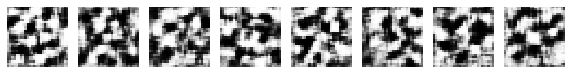

Epoch: 0
Discriminator loss: [0.71029395, 0.41796875]
Generator loss: [0.055190112, 1.0]


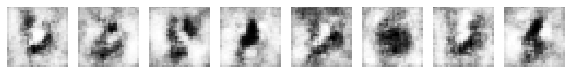

Epoch: 20
Discriminator loss: [0.64585024, 0.359375]
Generator loss: [0.66552716, 0.59375]


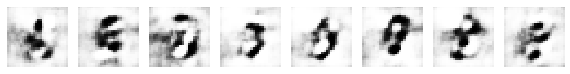

Epoch: 40
Discriminator loss: [0.57544994, 0.49609375]
Generator loss: [0.79067874, 0.3671875]


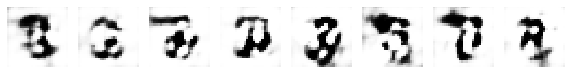

Epoch: 60
Discriminator loss: [0.56870836, 0.48828125]
Generator loss: [0.28814727, 0.9765625]


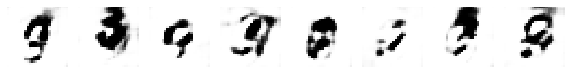

Epoch: 80
Discriminator loss: [0.5966812, 0.328125]
Generator loss: [1.0464461, 0.125]


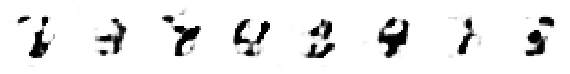

Epoch: 100
Discriminator loss: [0.6111541, 0.36328125]
Generator loss: [1.1064584, 0.0]


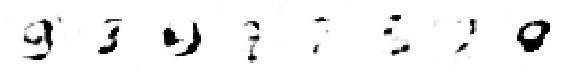

Epoch: 120
Discriminator loss: [0.55329925, 0.46484375]
Generator loss: [1.0879409, 0.0625]


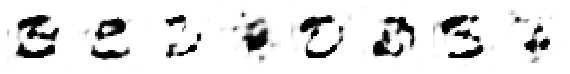

Epoch: 140
Discriminator loss: [0.5705824, 0.46484375]
Generator loss: [1.2820714, 0.0234375]


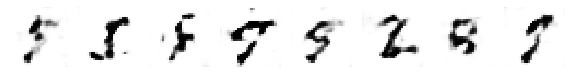

Epoch: 160
Discriminator loss: [0.6849473, 0.5]
Generator loss: [0.5205669, 0.8984375]


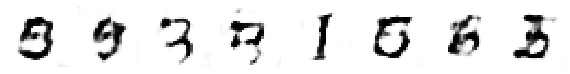

Epoch: 180
Discriminator loss: [0.6052271, 0.5]
Generator loss: [0.50982845, 0.875]


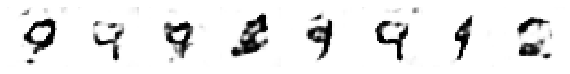

Epoch: 200
Discriminator loss: [0.9123503, 0.0078125]
Generator loss: [0.97209847, 0.1171875]


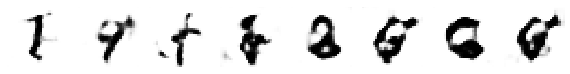

Epoch: 220
Discriminator loss: [0.63724947, 0.375]
Generator loss: [0.8801521, 0.2265625]


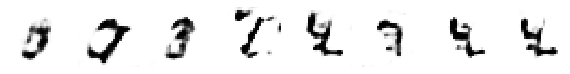

Epoch: 240
Discriminator loss: [0.57210636, 0.46875]
Generator loss: [1.1023774, 0.0703125]


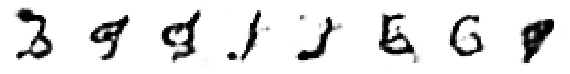

Epoch: 260
Discriminator loss: [0.6267657, 0.484375]
Generator loss: [0.9693327, 0.0546875]


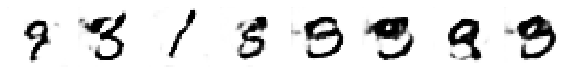

Epoch: 280
Discriminator loss: [0.6118557, 0.484375]
Generator loss: [0.8340107, 0.265625]


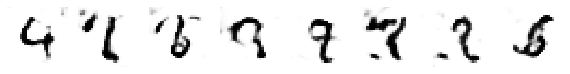

Epoch: 300
Discriminator loss: [0.63061154, 0.484375]
Generator loss: [0.9058166, 0.125]


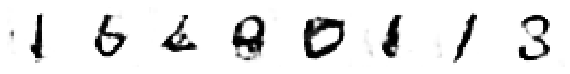

Epoch: 320
Discriminator loss: [0.6254798, 0.3984375]
Generator loss: [1.0172033, 0.1328125]


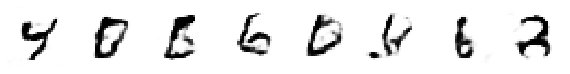

Epoch: 340
Discriminator loss: [0.63658607, 0.42578125]
Generator loss: [1.0113701, 0.0703125]


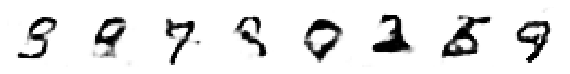

Epoch: 360
Discriminator loss: [0.65814394, 0.44140625]
Generator loss: [0.9444976, 0.1015625]


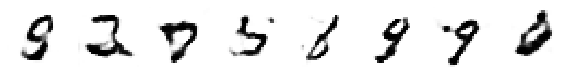

Epoch: 380
Discriminator loss: [0.62525034, 0.46484375]
Generator loss: [0.77453595, 0.40625]


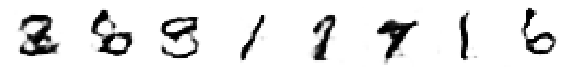

Epoch: 400
Discriminator loss: [0.64591336, 0.43359375]
Generator loss: [0.8288475, 0.3125]


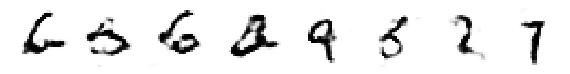

Epoch: 420
Discriminator loss: [0.6318182, 0.453125]
Generator loss: [0.9260027, 0.125]


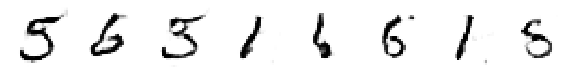

Epoch: 440
Discriminator loss: [0.593095, 0.4765625]
Generator loss: [1.0059546, 0.109375]


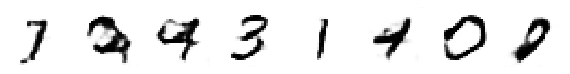

Epoch: 460
Discriminator loss: [0.64547956, 0.42578125]
Generator loss: [0.95493954, 0.078125]


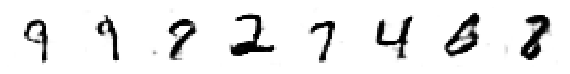

Epoch: 480
Discriminator loss: [0.6427705, 0.44921875]
Generator loss: [0.7827693, 0.3828125]


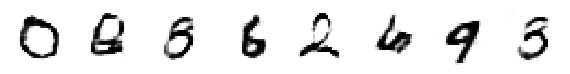

Epoch: 500
Discriminator loss: [0.61828613, 0.44921875]
Generator loss: [0.8460299, 0.234375]


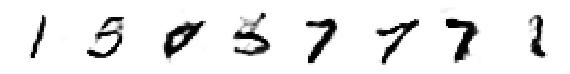

Epoch: 520
Discriminator loss: [0.6350967, 0.375]
Generator loss: [0.87549603, 0.21875]


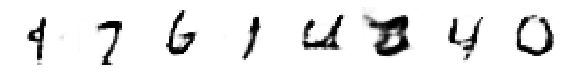

Epoch: 540
Discriminator loss: [0.63960433, 0.2890625]
Generator loss: [1.240288, 0.03125]


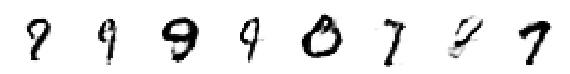

Epoch: 560
Discriminator loss: [0.64901084, 0.41796875]
Generator loss: [0.92033017, 0.1328125]


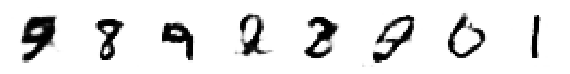

Epoch: 580
Discriminator loss: [0.64022213, 0.48046875]
Generator loss: [0.74605656, 0.4609375]


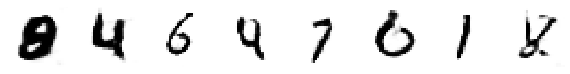

Epoch: 600
Discriminator loss: [0.64821535, 0.24609375]
Generator loss: [1.0694181, 0.0390625]


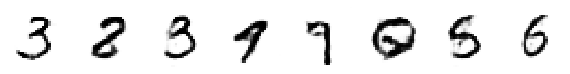

Epoch: 620
Discriminator loss: [0.6472008, 0.37890625]
Generator loss: [1.0435438, 0.03125]


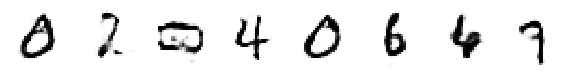

Epoch: 640
Discriminator loss: [0.6456685, 0.40625]
Generator loss: [0.91071135, 0.1796875]


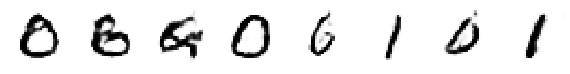

Epoch: 660
Discriminator loss: [0.6504186, 0.39453125]
Generator loss: [0.8397055, 0.265625]


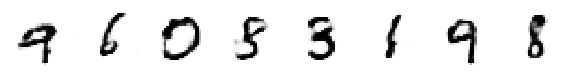

Epoch: 680
Discriminator loss: [0.6784376, 0.37890625]
Generator loss: [0.9844378, 0.09375]


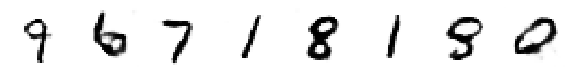

Epoch: 700
Discriminator loss: [0.6477334, 0.4921875]
Generator loss: [0.775929, 0.40625]


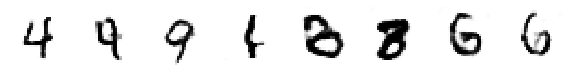

Epoch: 720
Discriminator loss: [0.65634286, 0.41796875]
Generator loss: [1.0081683, 0.0234375]


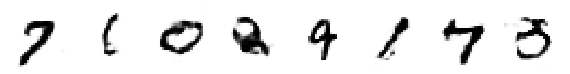

Epoch: 740
Discriminator loss: [0.6267991, 0.4296875]
Generator loss: [1.0430883, 0.0859375]


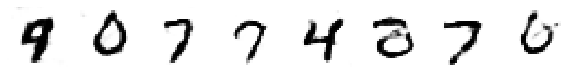

Epoch: 760
Discriminator loss: [0.6764563, 0.3125]
Generator loss: [0.8184855, 0.203125]


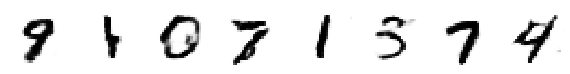

Epoch: 780
Discriminator loss: [0.6500765, 0.4296875]
Generator loss: [0.795617, 0.40625]


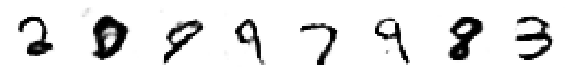

Epoch: 800
Discriminator loss: [0.6424091, 0.43359375]
Generator loss: [0.89450675, 0.140625]


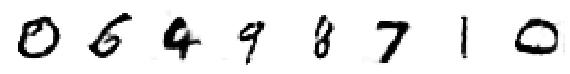

Epoch: 820
Discriminator loss: [0.63848764, 0.46484375]
Generator loss: [0.7927743, 0.3125]


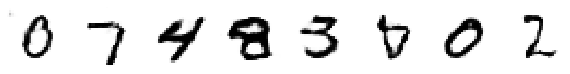

Epoch: 840
Discriminator loss: [0.63161194, 0.4609375]
Generator loss: [1.0104, 0.0625]


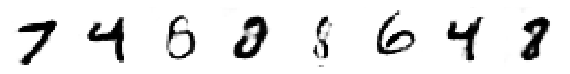

Epoch: 860
Discriminator loss: [0.6329646, 0.42578125]
Generator loss: [1.0008261, 0.09375]


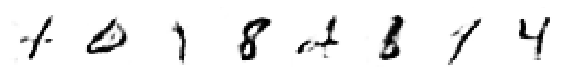

Epoch: 880
Discriminator loss: [0.6283785, 0.421875]
Generator loss: [0.9001042, 0.1796875]


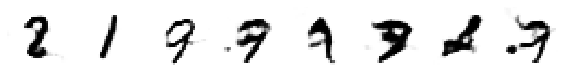

Epoch: 900
Discriminator loss: [0.6600657, 0.44140625]
Generator loss: [0.91152334, 0.1640625]


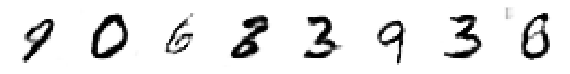

Epoch: 920
Discriminator loss: [0.6552646, 0.44921875]
Generator loss: [0.8854629, 0.140625]


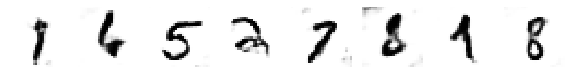

Epoch: 940
Discriminator loss: [0.6716646, 0.4921875]
Generator loss: [0.78887177, 0.359375]


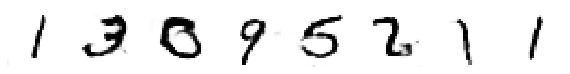

Epoch: 960
Discriminator loss: [0.64968336, 0.41796875]
Generator loss: [0.93764126, 0.15625]


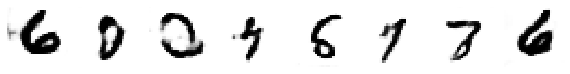

Epoch: 980
Discriminator loss: [0.650999, 0.359375]
Generator loss: [0.9583507, 0.078125]


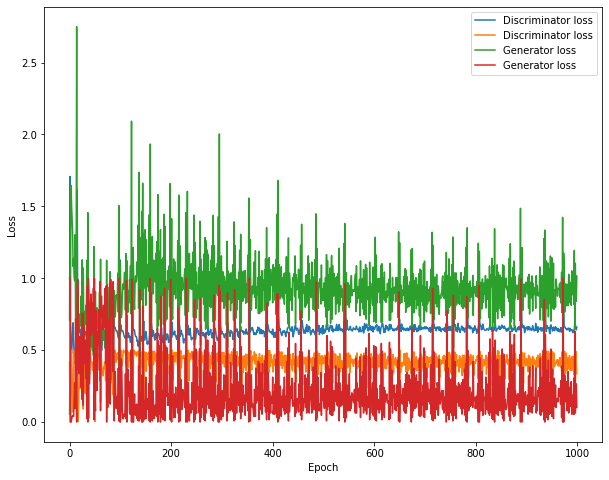

In [0]:
def main():
    # set hyper parameters    
    batch_size = 128   #데이터셋을 128크기로 쪼개서 학습
    epochs = 1000   #전체 데이터 1000번 반복
    learning_rate = 0.0002  
    z_input_dim = 100  #노이즈 차원을 크게만듬.
    n_iter_D = 1   #판별
    n_iter_G = 5  #생성

    # run model
    model = Model(batch_size, epochs, learning_rate, z_input_dim, n_iter_D, n_iter_G)
    model.fit()


if __name__ == '__main__':
    main()

# **모델 시각화**


In [0]:
!apt-get install graphviz
!pip install -q pydot
!pip install graphviz


from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


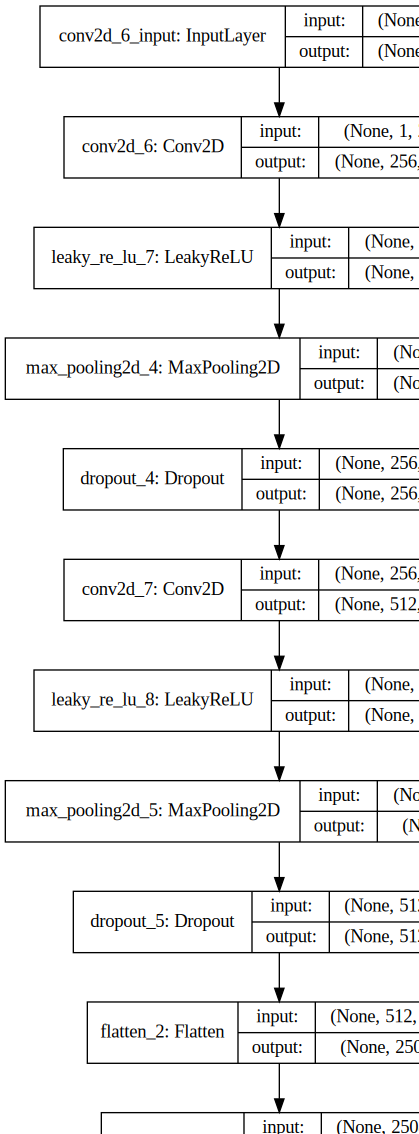

In [0]:
D = Sequential()  #처음 layer생성에 필요
D.add(Conv2D(256, (5, 5),
         padding='same',
         input_shape=(1, 28, 28),
         kernel_initializer=initializers.RandomNormal(stddev=0.02)))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Conv2D(512, (5, 5), padding='same'))
D.add(LeakyReLU(0.2))
D.add(MaxPooling2D(pool_size=(2, 2), strides=2))
D.add(Dropout(0.3))
D.add(Flatten())
D.add(Dense(256))
D.add(LeakyReLU(0.2))
D.add(Dropout(0.3))
D.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.0002, beta_1=0.5)
D.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(D, show_shapes=True).create(prog='dot', format='svg'))

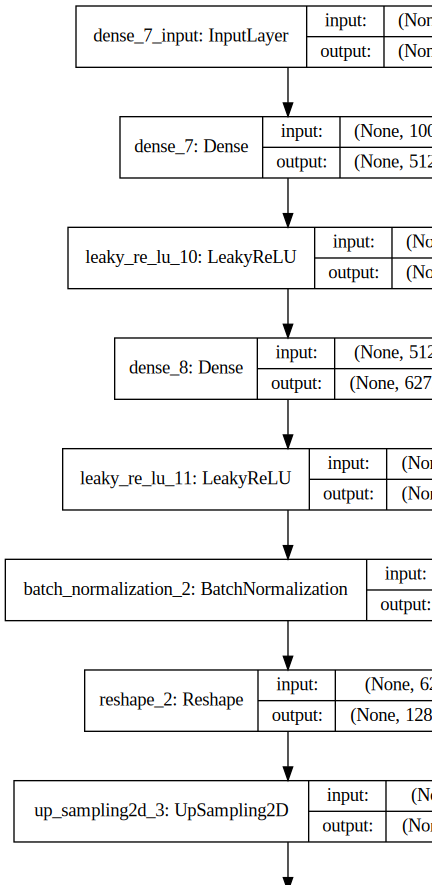

In [0]:
G = Sequential()
G.add(Dense(512, input_dim=100))
G.add(LeakyReLU(0.2))
G.add(Dense(128 * 7 * 7))
G.add(LeakyReLU(0.2))
G.add(BatchNormalization())
G.add(Reshape((128, 7, 7), input_shape=(128 * 7 * 7,)))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(64, (5, 5), padding='same', activation='tanh'))
G.add(UpSampling2D(size=(2, 2)))
G.add(Conv2D(1, (5, 5), padding='same', activation='tanh'))

adam = Adam(lr=0.0002, beta_1=0.5)
G.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

%matplotlib inline

SVG(model_to_dot(G, show_shapes=True).create(prog='dot', format='svg'))